In [9]:
import xgboost as xgb
import pandas as pd
from sklearn.metrics import roc_auc_score

In [10]:
# 読み出し
data = pd.read_pickle('data.pkl')
nomination_onehot = pd.read_pickle('nomination_onehot.pkl')
selected_performers_onehot = pd.read_pickle('selected_performers_onehot.pkl')
selected_directors_onehot = pd.read_pickle('selected_directors_onehot.pkl')
selected_studio_onehot = pd.read_pickle('selected_studio_onehot.pkl')
selected_scriptwriter_onehot = pd.read_pickle('selected_scriptwriter_onehot.pkl')
review_dataframe = pd.read_pickle('review_dataframe.pkl')
tfidf = pd.read_pickle('tfidf2.pkl')

In [11]:
from sklearn.decomposition import PCA

pca = PCA(n_components=20)
pca.fit(tfidf.values)
tfidf_df = pd.DataFrame(pca.transform(tfidf.values), index = tfidf.index)

In [12]:
table = pd.concat([
    data[['prize', 'title', 'year', 'screen_time']],
    nomination_onehot,
    selected_performers_onehot,
    selected_directors_onehot,
    selected_studio_onehot,
    selected_scriptwriter_onehot,
    tfidf
], axis = 1)

review_len = review_dataframe['reviews'].map(lambda s: len(s))
review_len.name = 'len'
year = table['year']

temp = pd.concat([year, review_len], axis = 1)

group = temp.groupby('year')

temp = temp.apply( lambda s: (s['len']-group.mean()['len'][s['year']] )/group.std()['len'][s['year']] , axis = 1)
temp.name = 'len'

# table['len'] = temp


In [13]:
# invalid

def logregobj(preds, dtrain):
    grad = - preds + dtrain
    grad[dtrain == 1] = 1
    grad[dtrain == 0] = -1
    hess = np.zeros(len(preds))
    return grad, hess


In [14]:
import numpy as np
import optuna

In [15]:
def objective(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth',1,10),
        'learning_rate': trial.suggest_uniform('learning_rate', 0.05, 0.2),
        'n_estimators': trial.suggest_int('n_estimators ', 20, 200),
        'n_jobs': 4,
        'gamma': trial.suggest_uniform('gamma', 0, 1),
        'reg_lambda': trial.suggest_uniform('reg_lambda', 0.5, 3),
        'reg_alpha': trial.suggest_uniform('reg_alpha', 0, 3)
    }

    print(param)
    
    l = []

    for year in range(1978, 2019 + 1):
        rg = xgb.XGBRegressor(silent= True, **param)
        X = table.query('year != {}'.format(year)).drop(['prize', 'title'], axis = 1).values
        y = table.query('year != {}'.format(year))['prize'].values
        rg.fit(X,y)
        result = rg.predict(table.query('year == {}'.format(year)).drop(['prize', 'title'], axis = 1).values)
        scope = table.query('year == {}'.format(year))[['title','prize']]
        scope['result'] = result
        l.append(scope)
        title = scope['title'].copy()
        title[scope['prize'] == 1] = title[scope['prize'] == 1].map(lambda s: '★' + s)
        #print(year)
        #print(pd.Series(result, index = title.values).sort_values(ascending=False) )
        #print('')
    

    temp = pd.concat(l)

    print(roc_auc_score(temp['prize'], temp['result']))
    return -roc_auc_score(temp['prize'], temp['result'])

study = optuna.create_study()
study.optimize(objective, n_trials=200)

{'max_depth': 9, 'learning_rate': 0.09107814867541635, 'n_estimators': 147, 'n_jobs': 4, 'gamma': 0.6537212485330672, 'reg_lambda': 2.323956818976772, 'reg_alpha': 2.1143525195392483}


KeyboardInterrupt: 

In [16]:
study.best_value

-0.7616229923922232

In [19]:
#best = study.best_params
best ={
    'max_depth': 1,
    'learning_rate': 0.14544434403253392,
    'n_estimators ': 72,
    'gamma': 0.4356018082020117,
    'reg_lambda': 2.931451663505623,
    'reg_alpha': 0.19045302677956732,
    'max_depth': 10
}

In [25]:
import datetime

import matplotlib
matplotlib.rcParams['font.family']='IPAGothic'
from matplotlib import pyplot as plt
%matplotlib inline

def model_to_histogram(model, features, fig_title):
    log_setting = False

    importances = model.feature_importances_
    indices = np.argsort(importances)

    plt.figure(figsize=(20, 20))
    plt.barh(range(len(indices)), importances[indices], color='r', align='center', log=log_setting)
    plt.yticks(range(len(indices)), features[indices])

    now = datetime.datetime.now()
    if log_setting is True:
        fig_path = "{}_log_{}.png".format(fig_title, now.strftime('%Y%m%d_%H%M%S'))
    else:
        fig_path = "{}_{}.png".format(fig_title, now.strftime('%Y%m%d_%H%M%S'))
    plt.savefig(fig_path)
    plt.show()

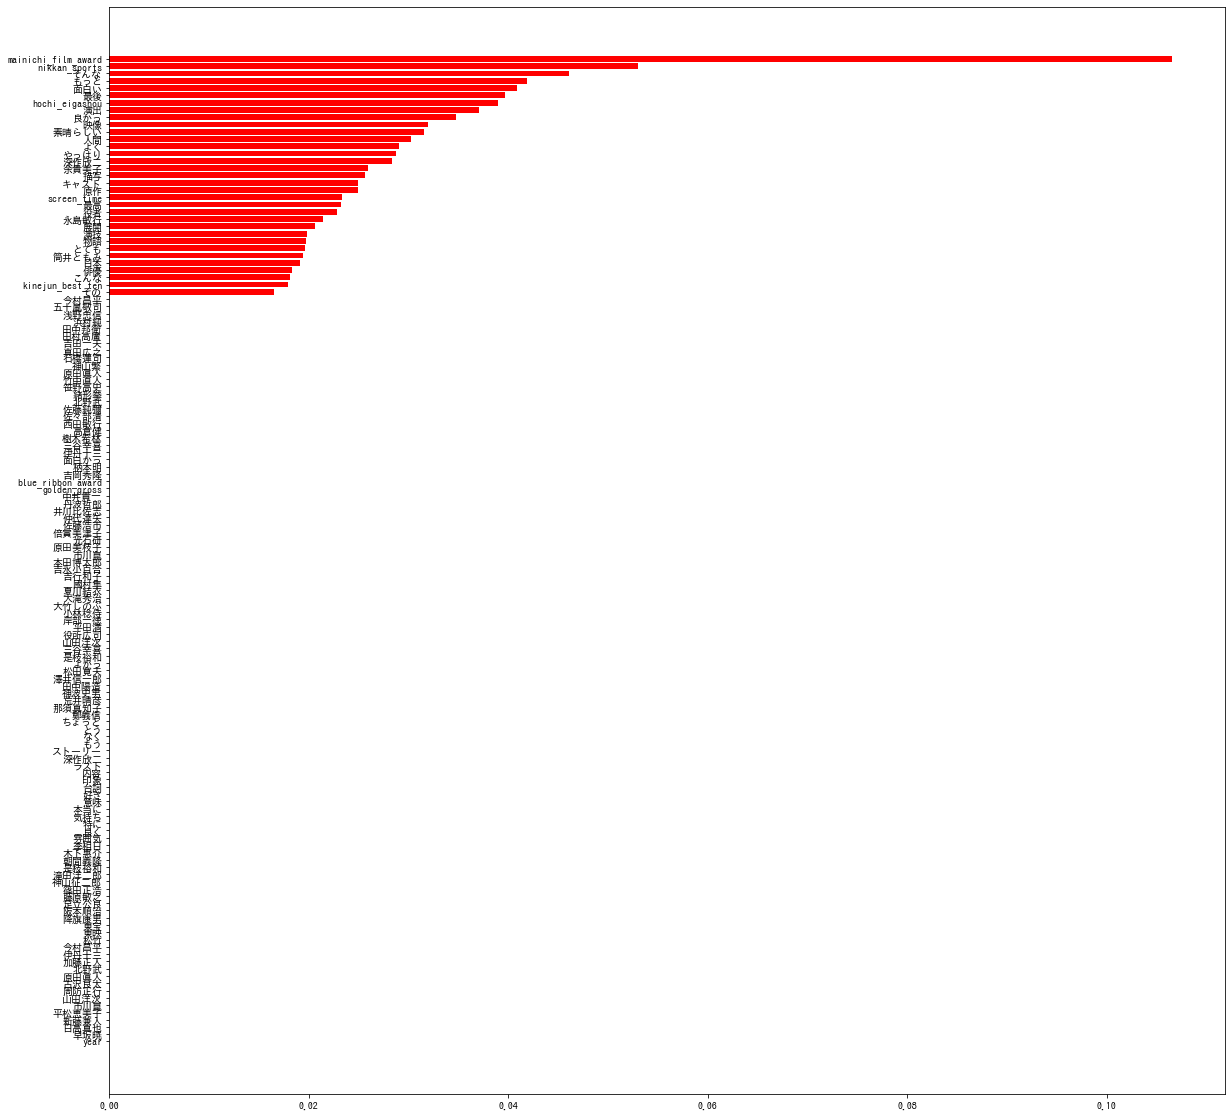

In [26]:
rg = xgb.XGBRegressor(silent = True,**best)
X = table.query('year != {}'.format(year)).drop(['prize', 'title'], axis = 1).values
y = table.query('year != {}'.format(year))['prize'].values
rg.fit(X, y)
feature_names = table.drop(['prize', 'title'], axis=1).columns
model_to_histogram(rg, feature_names, "tfidf_hist")

In [18]:
l = []

allelement = 0

count = 0

for year in range(1978, 2019 + 1):
    param = {
        'silent': True,
        'max_depth': 10,
    }
    rg = xgb.XGBRegressor(silent = True,**best)
    X = table.query('year != {}'.format(year)).drop(['prize', 'title'], axis = 1).values
    y = table.query('year != {}'.format(year))['prize'].values
    rg.fit(X,y)
    result = rg.predict(table.query('year == {}'.format(year)).drop(['prize', 'title'], axis = 1).values)
    scope = table.query('year == {}'.format(year))[['title','prize']]
    scope['result'] = result
    l.append(scope)
    title = scope['title'].copy()
    title[scope['prize'] == 1] = title[scope['prize'] == 1].map(lambda s: '★' + s)
    print(year)
    disp = pd.Series(result, index = title.values).sort_values(ascending=False)
    print(disp)
    print('')
    allelement  += 1
    if '★' in disp.index[0]:
        count += 1
        
    
temp = pd.concat(l)
print(roc_auc_score(temp['prize'], temp['result']))
print(count,'/',allelement)

1978
★幸福の黄色いハンカチ       0.397213
八甲田山              0.313442
はなれ瞽女おりん          0.088507
竹山ひとり旅            0.088507
青春の門 自立篇（1977）    0.088507
dtype: float32

1979
★事件        0.429888
鬼畜         0.316959
サード        0.170334
愛の亡霊       0.088928
柳生一族の陰謀    0.022150
dtype: float32

1980
あゝ野麦峠         0.307602
太陽を盗んだ男       0.267096
★復讐するは我にあり    0.176563
もう頬づえはつかない    0.087150
衝動殺人 息子よ      0.087150
dtype: float32

1981
★ツィゴイネルワイゼン    0.213119
遙かなる山の呼び声      0.108623
二百三高地          0.086810
動乱             0.086810
父よ母よ!          0.086810
dtype: float32

1982
泥の河                0.410817
遠雷                 0.288641
★駅/STATION         0.155100
日本の熱い日々 謀殺・下山事件    0.126835
ええじゃないか            0.086816
dtype: float32

1983
★蒲田行進曲      0.432488
誘拐報道        0.154498
疑惑          0.109952
未完の対局       0.090901
鬼龍院花子の生涯    0.061638
dtype: float32

1984
戦場のメリークリスマス    0.276884
細雪（1983）       0.182414
★楢山節考          0.182414
家族ゲーム          0.174531
南極物語（1983）     0.160130
dtype: float32

1985
★お葬式        0